# Processing supreme data

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import warp, warp_polar
import supreme as sp

#awojdyla@lbl.gov
#October 2020

### Load the data

In [2]:
filename = "01_test.tiff"

# read the image
im_tiff = Image.open(filename)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[0], im_tiff.size[1], 1))

# metadata
# pixel size
dx_m = 1e-6
# screen size
Dx_m = 2e-3-dx_m

x_m = np.linspace(-Dx_m/2, Dx_m/2, int(np.ceil(Dx_m/dx_m)))

### pre-process data

In [3]:
# take the Fourier Transform
IMG = sp.ft(im_np)

# corresponding frequency scale
f_cpm = sp.fs(x_m)


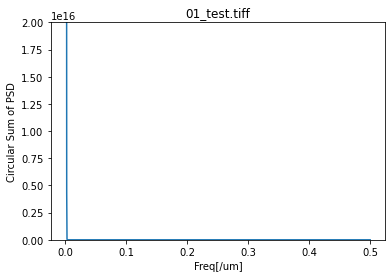

In [4]:
CIRCSUM = sp.azimuthal_avg(np.abs(IMG)**2)

# positive frequencies
Np = int(np.floor((len(IMG)+1)/2))
fp_cpm = f_cpm[Np:]

plt.cla()
plt.plot(fp_cpm*1e-6,CIRCSUM[0:(Np-1)])
plt.title(filename)
plt.xlabel('Freq[/um]')
plt.ylabel('Circular Sum of PSD')
plt.ylim((0,20000e12))
plt.show()

## Create a model that matches

In [5]:
# Chirp model:

# Setting the frequency scale axis of the chirp to match that of the signal.
f_min_cpm = 0.01e6
f_max_cpm = 0.2e6

mask_fopt = np.where((f_cpm>=f_min_cpm) & (f_cpm<=f_max_cpm))
mask2_fopt = np.where((fp_cpm>=f_min_cpm) & (fp_cpm<=f_max_cpm))

ff_cpm = f_cpm[mask_fopt] 

# definition of the model
lambda_m = 1e-6
chirp_opt = lambda X: X[2] * abs(np.sin(np.pi*X[0]*lambda_m*ff_cpm**2))**2 + X[1]



In [6]:
# Initial guess

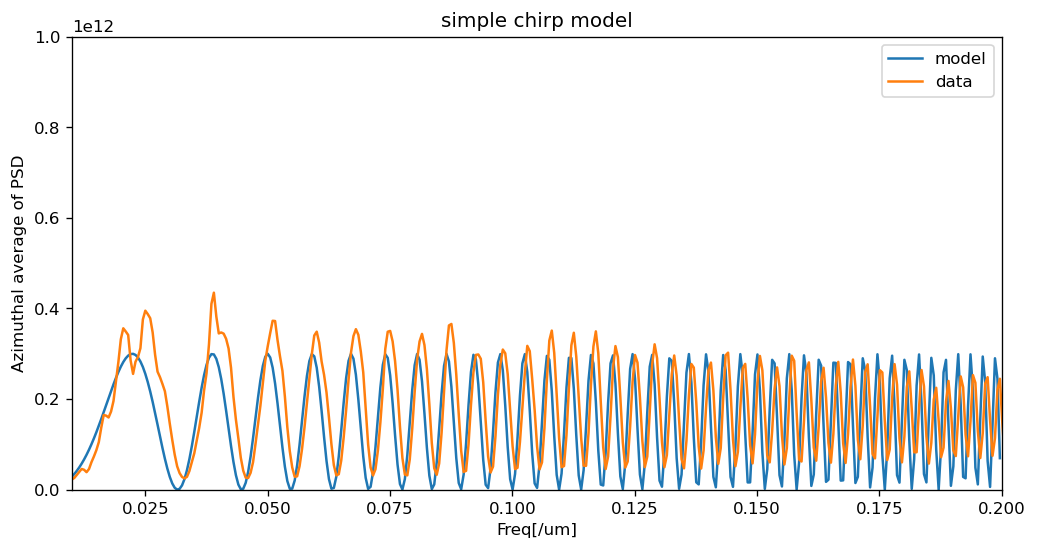

In [7]:
z0_m = 1e-3*(1+0e-3)
X0= [z0_m,0,0.3e12]

fig=plt.figure(figsize=(10, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.plot((ff_cpm) * 1e-6,chirp_opt(X0), fp_cpm*1e-6,CIRCSUM[0:(Np-1)])
plt.xlabel('Freq[/um]')
plt.ylabel('Azimuthal average of PSD')
plt.title('simple chirp model')
plt.legend(('model','data'))
plt.xlim((f_min_cpm*1e-6,f_max_cpm*1e-6))
plt.ylim((0,1e12))
plt.show() 

In [8]:
import scipy.optimize
cost_func = lambda X: np.sum(np.abs(CIRCSUM[mask2_fopt] - chirp_opt(X))**2)
X = scipy.optimize.fmin(cost_func, x0=X0)

# best guess for distance
zg_m = X[0]

Optimization terminated successfully.
         Current function value: 1251975911590642357108736.000000
         Iterations: 159
         Function evaluations: 348


## check best solution

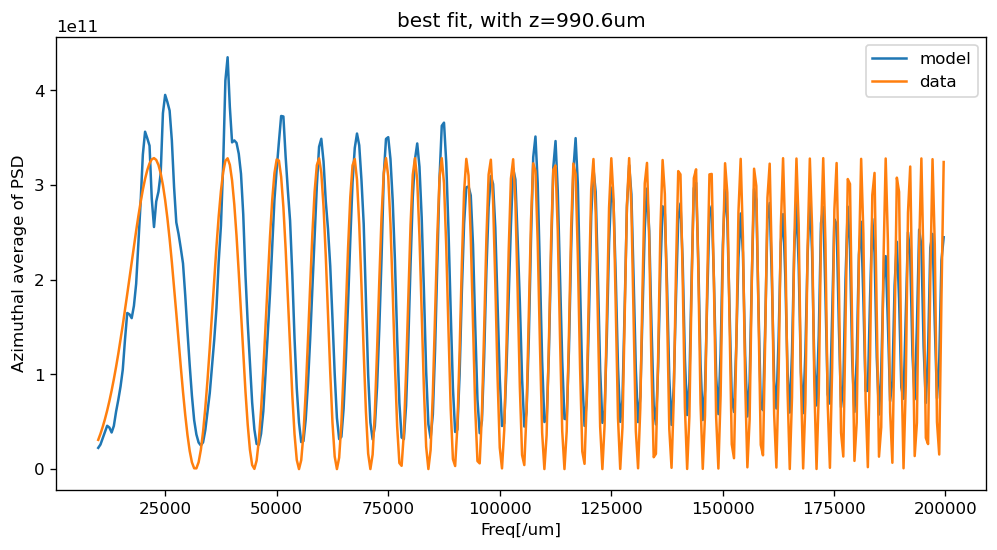

In [9]:
#plt.plot(np.abs(CIRCSUM[mask_fopt] - chirp_opt(X0))**2)
fig=plt.figure(figsize=(10, 5), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(ff_cpm, CIRCSUM[mask2_fopt],ff_cpm, chirp_opt(X))
plt.title('best fit, with z=%1.1fum'%(zg_m*1e6))
plt.legend(('model','data'))
plt.xlabel('Freq[/um]')
plt.ylabel('Azimuthal average of PSD')
plt.show()